# Testing the DBCV score: how well can it find good tuning parameters for the DBSCAN?


Running clustering for Year Range: 2002-2005

Running K-Means with parameters {'n_clusters': 3}
Calculating DBCV score for K-Means with parameters {'n_clusters': 3}
-0.9572942277426469

Running K-Means with parameters {'n_clusters': 4}
Calculating DBCV score for K-Means with parameters {'n_clusters': 4}
-0.9301861525703876

Running K-Means with parameters {'n_clusters': 5}
Calculating DBCV score for K-Means with parameters {'n_clusters': 5}
-0.9379737418458471

Running K-Means with parameters {'n_clusters': 6}
Calculating DBCV score for K-Means with parameters {'n_clusters': 6}
-0.9327476944681137

Running K-Means with parameters {'n_clusters': 7}
Calculating DBCV score for K-Means with parameters {'n_clusters': 7}
-0.929510953024821

Running K-Means with parameters {'n_clusters': 8}
Calculating DBCV score for K-Means with parameters {'n_clusters': 8}
-0.9180810389608862

Running DBSCAN with parameters {'eps': 0.05, 'min_samples': 25}
Calculating DBCV score for DBSCAN with parameters 

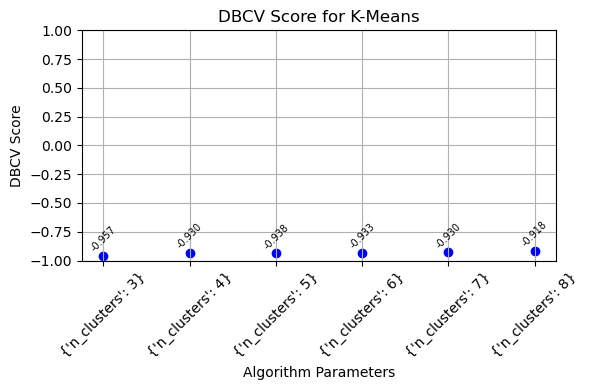

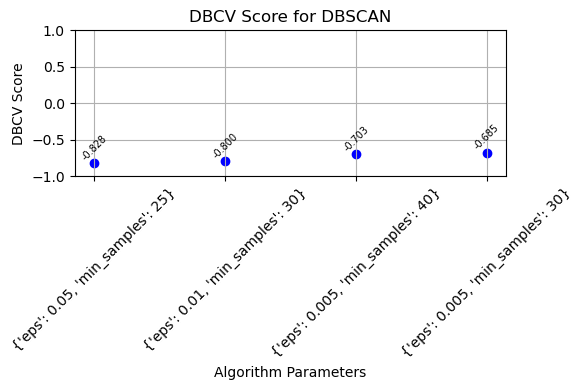

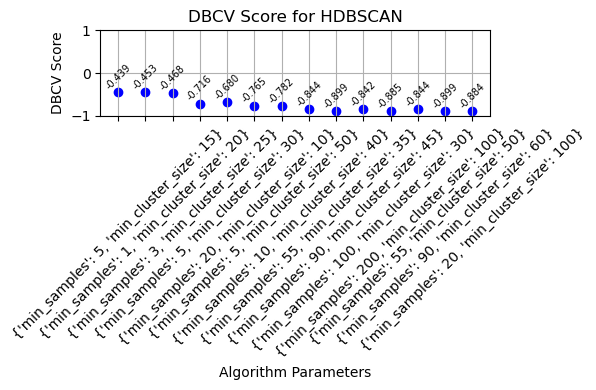

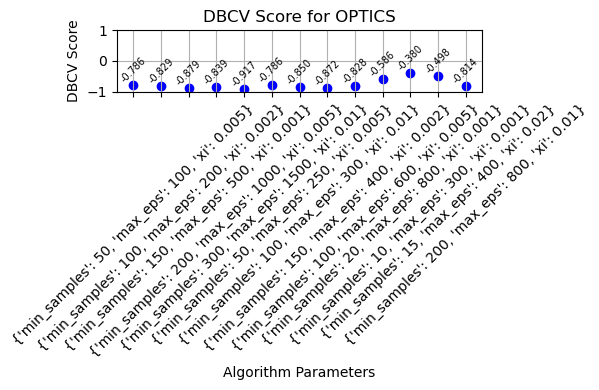

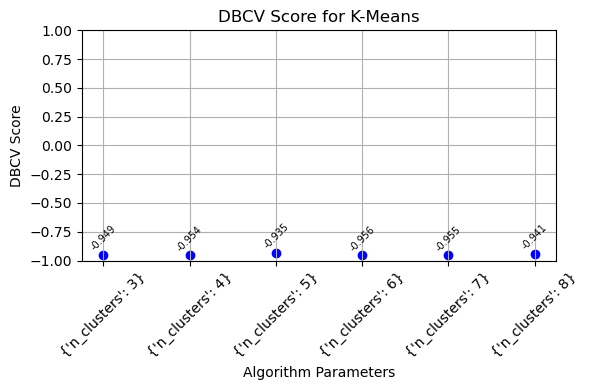

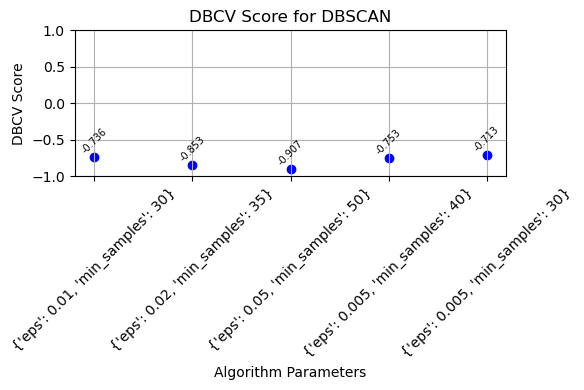

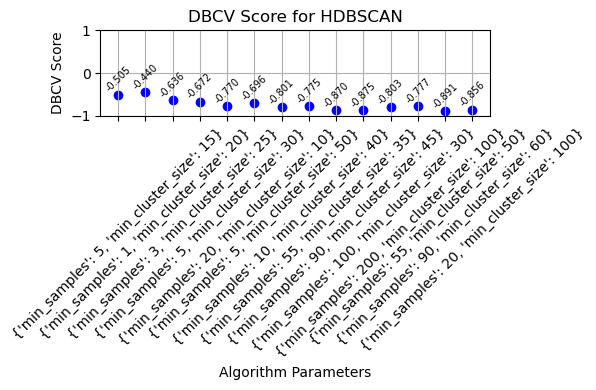

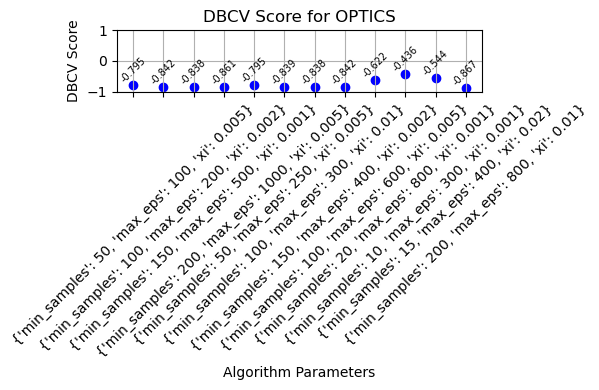

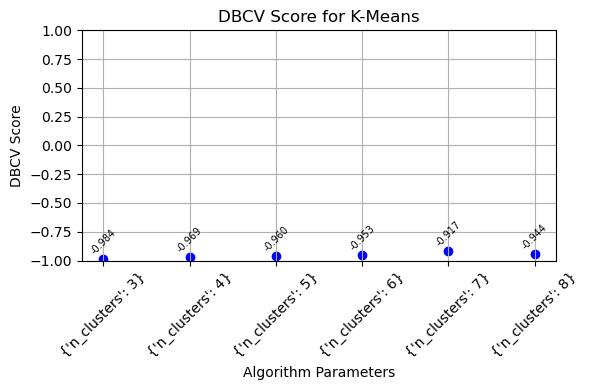

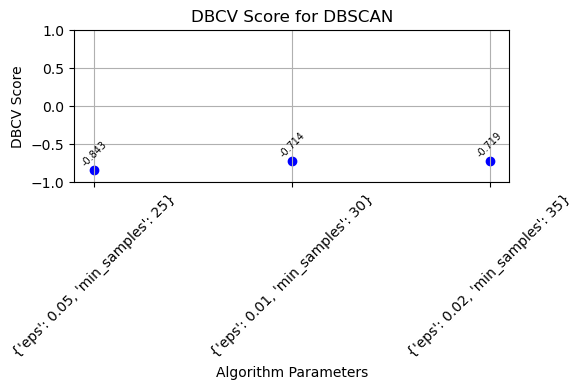

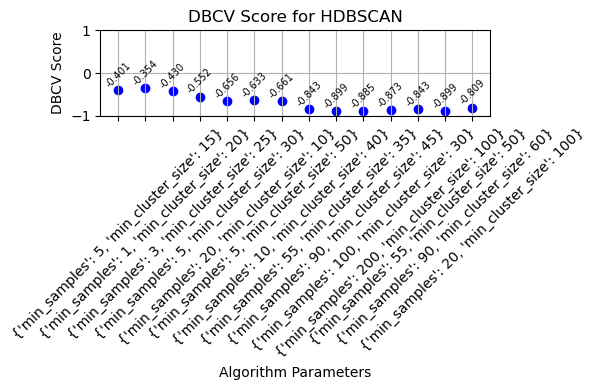

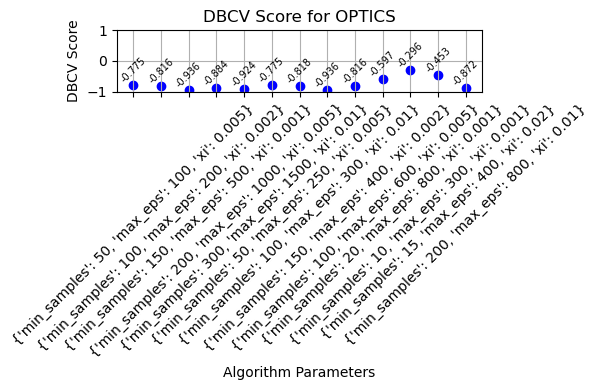

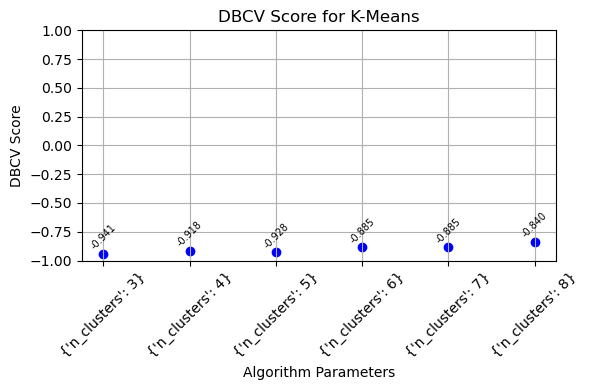

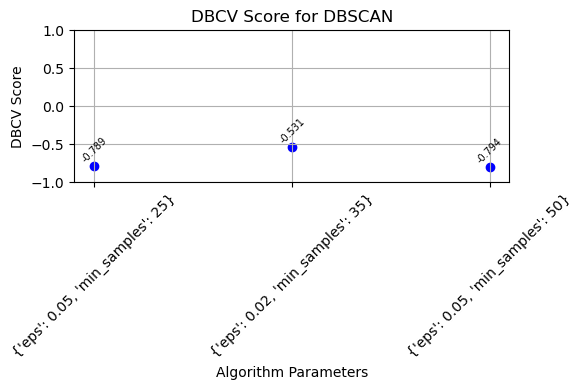

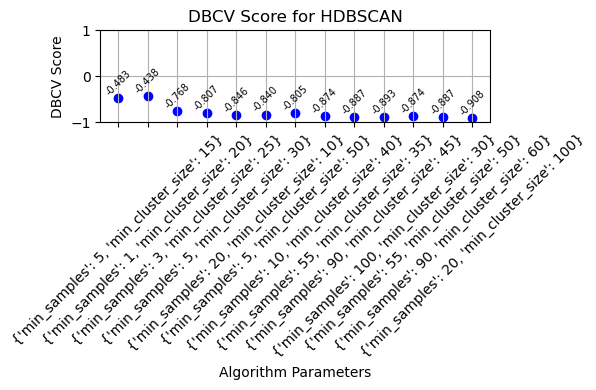

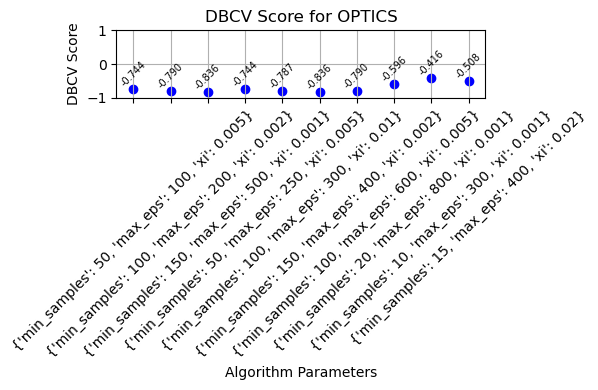

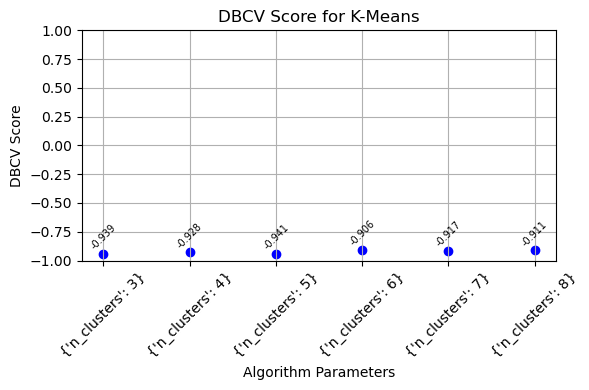

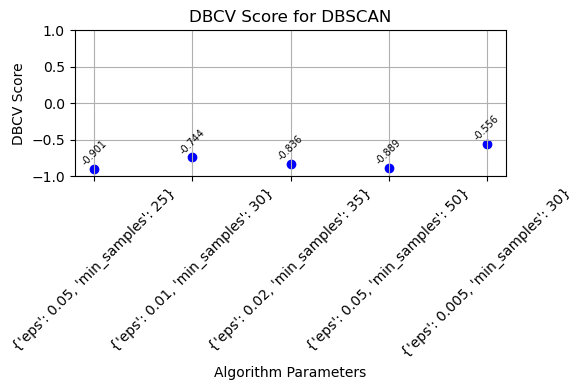

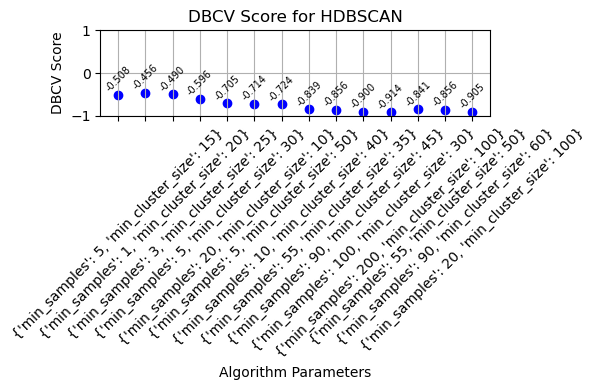

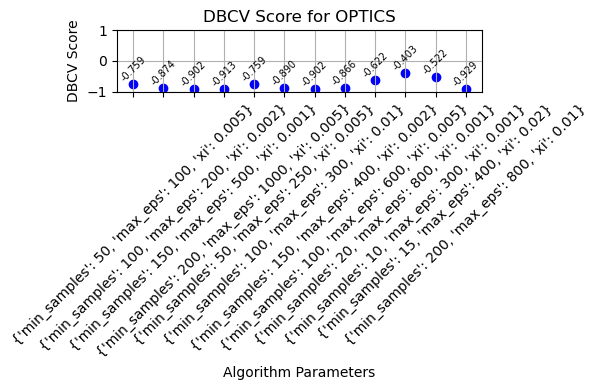

In [3]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt

from OPTICS import optics_clustering
from kmeans import k_means
from HDBSCAN import hdbscan_clustering
from DBSCAN import dbscan_clustering

from cluster_data import normalize_data, unnormalize
from cluster_plotter import ClusterPlotter
from cluster_data import run_clustering
import cluster_data
import scores
import cluster_plotter
import my_dbcv_module

# Files for uncorr_observed_data
uncorr_obs_files = {
    year: f"ogs{year}01_12_det.ele_ucorr" if year != 2002 else f"ogs{year}08_12_det.ele_ucorr"
    for year in range(2002, 2024) if year != 2018  # Exclude 2018, missing
}

# Standard year ranges
standard_year_ranges = {f"{start}-{start + 3}": np.arange(start, start + 4) for start in [2002, 2006, 2010, 2014]}
standard_year_ranges["2019-2023"] = np.arange(2019, 2024)

# Running ranges
running_ranges = cluster_data.generate_running_year_ranges(2002, 2023, 4)
year_ranges = standard_year_ranges

# Bin observed data
binned_data = cluster_data.bin_observed_data(uncorr_obs_files, year_ranges, print_res=False)
results_per_year_range = {}

# Directory for saving plots
plot_dir = "Images/comparison_algorithms_dbcv"
os.makedirs(plot_dir, exist_ok=True)
cluster_plotter.clear_directory(plot_dir)

# Define score columns (needed for correlation matrices)
score_columns = ["DBCV Score"]

# Process each binned data set
for cluster_data_single, year_range in binned_data:
    print(f"\nRunning clustering for Year Range: {year_range}")

    # Prepare data array
    data_array = np.array([cluster_data_single.inc, cluster_data_single.raan]).T
    normalized_data, data_min, data_max = normalize_data(data_array)

    # Algorithms and parameters
    algorithms = {
            'K-Means': {'model': k_means, 'params': [{'n_clusters': 3}, {'n_clusters': 4}, {'n_clusters': 5}, {'n_clusters': 6}, {'n_clusters': 7}, {'n_clusters': 8}]},
            'DBSCAN': {'model': dbscan_clustering, 'params': [
                {'eps': 0.05, 'min_samples': 25}, 
                {'eps': 0.01, 'min_samples': 30}, 
                {'eps': 0.02, 'min_samples': 35},
                {'eps': 0.1, 'min_samples': 20}, 
                {'eps': 0.15, 'min_samples': 40}, 
                {'eps': 0.05, 'min_samples': 50}, 
                {'eps': 0.005, 'min_samples': 40}, 
                {'eps': 0.001, 'min_samples': 40}, 
                {'eps': 0.002, 'min_samples': 40}, 
                {'eps': 0.0001, 'min_samples': 30}, 
                {'eps': 0.005, 'min_samples': 30}, 
                {'eps': 0.001, 'min_samples': 30}, 
                {'eps': 0.002, 'min_samples': 30}, 
                {'eps': 0.0001, 'min_samples': 30}
            ]},
            'HDBSCAN': {'model': hdbscan_clustering, 'params': [
                {'min_samples': 5, 'min_cluster_size': 15}, 
                {'min_samples': 1, 'min_cluster_size': 20}, 
                {'min_samples': 3, 'min_cluster_size': 25},
                {'min_samples': 5, 'min_cluster_size': 30},
                {'min_samples': 20, 'min_cluster_size': 10},
                {'min_samples': 5, 'min_cluster_size': 50},
                {'min_samples': 10, 'min_cluster_size': 40},
                {'min_samples': 55, 'min_cluster_size': 35},
                {'min_samples': 90, 'min_cluster_size': 45},
                {'min_samples': 100, 'min_cluster_size': 30}, 
                {'min_samples': 200, 'min_cluster_size': 100},
                {'min_samples': 55, 'min_cluster_size': 50},
                {'min_samples': 90, 'min_cluster_size': 60},
                {'min_samples': 20, 'min_cluster_size': 100}
            ]},
            'OPTICS': {'model': optics_clustering, 'params': [
                {'min_samples': 50, 'max_eps': 100, 'xi': 0.005},
                {'min_samples': 100, 'max_eps': 200, 'xi': 0.002},
                {'min_samples': 150, 'max_eps': 500, 'xi': 0.001},
                {'min_samples': 200, 'max_eps': 1000, 'xi': 0.005},
                {'min_samples': 300, 'max_eps': 1500, 'xi': 0.01},
                {'min_samples': 50, 'max_eps': 250, 'xi': 0.005},
                {'min_samples': 100, 'max_eps': 300, 'xi': 0.01},
                {'min_samples': 150, 'max_eps': 400, 'xi': 0.002},
                {'min_samples': 100, 'max_eps': 600, 'xi': 0.005},
                {'min_samples': 20, 'max_eps': 800, 'xi': 0.001}, 
                {'min_samples': 10, 'max_eps': 300, 'xi': 0.001},
                {'min_samples': 15, 'max_eps': 400, 'xi': 0.02},
                {'min_samples': 100, 'max_eps': 600, 'xi': 0.05},
                {'min_samples': 200, 'max_eps': 800, 'xi': 0.01},
            ]}
        }


    results = []
    dbcv_scores = []
    
    for algo_name, algo_info in algorithms.items():
        for params in algo_info['params']:
            print(f"\nRunning {algo_name} with parameters {params}")

            if algo_name == "K-Means":
                model = k_means(normalized_data, k=params['n_clusters'])
                labels = model.labels
                n_clusters = len(set(labels))

            elif algo_name == "DBSCAN":
                model = dbscan_clustering(normalized_data, eps=params['eps'], min_samples=params['min_samples'])
                labels = model.labels
                n_clusters = len(set(labels)) - (1 if -1 in labels else 0)

            elif algo_name == "HDBSCAN":
                model = hdbscan_clustering(normalized_data, min_cluster_size=params['min_cluster_size'], min_samples=params['min_samples'])
                labels = model.labels
                n_clusters = len(set(labels)) - (1 if -1 in labels else 0)

            elif algo_name == "OPTICS":
                model = optics_clustering(normalized_data, min_samples=params['min_samples'], max_eps=params['max_eps'], xi=params['xi'])
                labels = model.labels
                n_clusters = len(set(labels)) - (1 if -1 in labels else 0)

            if n_clusters > 1:
                try:
                    print(f"Calculating DBCV score for {algo_name} with parameters {params}")
                    dbcv_score = scores.DBCV_score_rust(model)
                    print(dbcv_score)
                    dbcv_scores.append(dbcv_score)

                    results.append({
                        "Algorithm": algo_name,
                        "Parameters": str(params),  # Store as string for better handling in plots
                        "DBCV Score": dbcv_score,
                        "Clusters": n_clusters
                    })

                except ValueError as e:
                    print(f"Error calculating scores: {e}")
                    pass

    # Create a scatter plot for each algorithm
    for algo_name in algorithms.keys():
        algo_results = [result for result in results if result["Algorithm"] == algo_name]
        if algo_results:
            df_algo = pd.DataFrame(algo_results)

            # Create a new figure for each algorithm
            plt.figure(figsize=(6, 4))
            ax = plt.gca()

            # Scatter plot with parameters as x and DBCV Score as y
            ax.scatter(df_algo['Parameters'].astype(str), df_algo['DBCV Score'], color='blue')

            # Annotate each point with its DBCV Score value
            for i, row in df_algo.iterrows():
                ax.text(
                    i,
                    row["DBCV Score"] + 0.02,       # a little above the point
                    f"{row['DBCV Score']:.3f}",
                    ha="center",
                    va="bottom",
                    fontsize=7,
                    rotation=45
                )

            ax.set_title(f"DBCV Score for {algo_name}")
            ax.set_ylim(-1, 1)  # Scores between -1 and 1
            ax.set_xlabel('Algorithm Parameters')
            ax.set_ylabel('DBCV Score')
            plt.xticks(rotation=45)

            # Save and show each plot
            algo_plot_dir = os.path.join(plot_dir, algo_name)
            os.makedirs(algo_plot_dir, exist_ok=True)
            plt.tight_layout()
            plt.grid()
            plt.savefig(os.path.join(algo_plot_dir, f"{algo_name}_dbcv.png"))
